# Securing an Atoti session with Auth0 using OIDC

💡 **Note:** Security implementation is one of the [locked features](https://docs.atoti.io/latest/how_tos/unlock_all_features.html#Unlock-all-features) that are not available in Atoti Community Edition. To try out this notebook, you can request for an [evaluation license](https://atoti.io/evaluation-license-request/) to unlock all features. 

Atoti supports multiple [authentication mechanisms](https://docs.activeviam.com/products/atoti/python-sdk/0.9.6/api/atoti.security.html) to cater to the needs of our end users. Securing a session comes in two parts:

1. Implementing authentication mechanism to secure access to the session
2. Restricting access of modules or data access by users based on the roles granted

This notebook demonstrates how we use [OpenID Connect (OIDC)](https://openid.net/connect/) via [Auth0](https://auth0.com/) to implement security over the Atoti web application. We will explore the Atoti security features using the [Top 50 Fast Food](https://www.kaggle.com/datasets/stetsondone/top50fastfood) dataset from Kaggle, combined with its parent company information sourced from the internet.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=oidc-auth0" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

## Import libraries

In [1]:
import os
import requests
import atoti as tt
from requests.auth import HTTPBasicAuth
from urllib.parse import urlparse

## Setting up Auth0

Before we can use Auth0 for authentication with Atoti, we'll need to create and configure an Auth0 application.

### Create Auth0 application

Navigate to *Applications* > *Create Application*. Then, create an Auth0 application named `Atoti-Auth0` and choose the `Regular Web Applications` application type.


![auth0-setup-applications-dashboard.png](https://data.atoti.io/notebooks/security/img/auth0-setup-applications-dashboard.png)



### Configuring Auth0 application

Next, set the following environment variables with the credentials listed in the *Settings* tab of the `Atoti-Auth0` application. This information will be used when configuring authentication for the Atoti session.

For Linux/macOS users:

```bash
export AUTH0_NAMESPACE=
export AUTH0_CLIENT_ID=
export AUTH0_CLIENT_SECRET=
```

For Windows OS users:

```bash
set AUTH0_NAMESPACE=
set AUTH0_CLIENT_ID=
set AUTH0_CLIENT_SECRET=
```

![auth0-setup-configure-application-1.png](https://data.atoti.io/notebooks/security/img/auth0-setup-configure-application-1.png)

In addition, set the following allowed URLs for the Auth0 application. The callback URL should be set to `auth0` for the [provider id](https://docs.atoti.io/0.9.6/api/atoti.OidcConfig.html#atoti.OidcConfig.provider_id):

```python
f"{session_url}/login/oauth2/code/{provider_id}"
```


* Allowed Callback URLs:
  * `http://localhost:9097, http://localhost:9097/login/oauth2/code/auth0`
* Allowed Logout URLs:
  * `http://localhost:9097`
* Allowed Web Origins:
  * `http://localhost:9097`

![auth0-setup-configure-application-2.png](https://data.atoti.io/notebooks/security/img/auth0-setup-configure-application-2.png)

### Create Auth0 action

We'll also need to configure an Auth0 action. Go to *Actions* > *Library* > *Create Action* > *Build from scratch*. 

![auth0-setup-custom-action-1.png](https://data.atoti.io/notebooks/security/img/auth0-setup-custom-action-1.png)

Next, configure the action with the following code snippet. This links an authorized user to its assigned Auth0 roles upon log in or authentication. Atoti will then map the Auth0 roles to Atoti roles.

💡 **Note:** Replace the `namespace` value with your specific Auth0 domain.

```javascript
exports.onExecutePostLogin = async (event, api) => {
  const namespace = 'https://dev-5m2svhd0.us.auth0.com';
  if (event.authorization) {
    api.idToken.setCustomClaim(`${namespace}/roles`, event.authorization.roles);
    api.accessToken.setCustomClaim(`${namespace}/roles`, event.authorization.roles);
  }
};
```

![auth0-setup-custom-action-2.png](https://data.atoti.io/notebooks/security/img/auth0-setup-custom-action-2.png)

Then, add the custom action to the `Post Login` trigger. Go to *Actions* > *Triggers* > *post-login* and drag-and-drop the `Atoti-Auth0` action to the workflow.

![auth0-setup-custom-action-3.png](https://data.atoti.io/notebooks/security/img/auth0-setup-custom-action-3.png)

### Create Auth0 users

We'll also need to create a user that will authenticating with Auth0 when signing into the Atoti session.

Go to *User Management* > *Users* > *Create User* and create a new user with a `Username-Password-Authentication` connection type.

![auth0-setup-users-1.png](https://data.atoti.io/notebooks/security/img/auth0-setup-users-1.png)

### Create Auth0 roles

Set the following role mapping in Auth0. The Auth0 roles will map to the corresponding Atoti roles when assigned to an authenticated user. This mapping will also need to be done on the Atoti session configuration side. 

* `AUTH0_ADMIN`: `ROLE_ADMIN`
* `AUTH0_USER`: `ROLE_USER`
* `AUTH0_ROLE_SHARE`: `ROLE_SHARE`
* `AUTH0_ROLE_BURGER`: `ROLE_BURGER`
* `AUTH0_ROLE_INSPIRE`: `ROLE_INSPIRE`
* `AUTH0_ROLE_RESTAURANT`: `ROLE_RESTAURANT`
* `AUTH0_ROLE_SNACK`: `ROLE_SNACK`

![auth0-setup-roles-1.png](https://data.atoti.io/notebooks/security/img/auth0-setup-roles-1.png)

## Setting up Atoti

It is important to fix the port for Atoti web application as we will require it to configure the application URIs in Auth0.  



During the initial setup, it is useful to configure the [Spring Security logging](https://www.baeldung.com/spring-security-enable-logging) to help in debugging any potential issues in the connectivity.  
As shown in the above code snippet, we can turn on logging with `logging.level.org.springframework.security` set to the `DEBUG` level using the `java_options`.

In [2]:
authentication = tt.OidcConfig(
    provider_id="auth0",
    issuer_url=f"https://{os.environ['AUTH0_DOMAIN']}/",
    client_id=os.environ["AUTH0_CLIENT_ID"],
    client_secret=os.environ["AUTH0_CLIENT_SECRET"],
    name_claim="name",
    scopes={"openid", "email", "profile", "roles"},
    roles_claims=[
        f"https://{os.environ['AUTH0_DOMAIN']}/roles",
    ],
)

session = tt.Session.start(
    tt.SessionConfig(
        port=9097,
        security=tt.SecurityConfig(sso=authentication),
        user_content_storage="./content-02",
        java_options=["-Dlogging.level.org.springframework.security=DEBUG"],
    )
)

Once the session is created, we can proceed with the usual data loading into Atoti table, cube and measures creation. Remember to re-execute these cells if you have changed the mode of authentication.

Client IDs and secrets should be kept private. As suggested in the [documentation](https://docs.atoti.io/latest/how_tos/secure_a_session.html#Configuring-the-authentication-mechanism), connection details can be read from environment variables for improved security.  

### Create table and load data

Although we can [`create_table`](https://docs.atoti.io/latest/api/atoti.Session.create_table.html#atoti.Session.create_table) before loading data in, we used `read_csv` in our example to create and load data into the Atoti tables.

In [3]:
base_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/security/data/parent_co.csv",
    table_name="parent_co",
    keys=["company", "parent_company"],
    process_quotes=True,
)
base_tbl.head()

,,name
parent_company,company,
Inspire Brands,arbys,Arby's
"Culver Franchising System, LLC",culvers,Culver's
"Papa Murphy's Holdings, Inc.",papa_murphys,Papa Murphy's
"Tropical Smoothie Cafe, LLC",tropical_smoothie,Tropical Smoothie Café
Focus Brands,auntie_annes,Auntie Anne's


In [4]:
enrichment_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/security/data/top_50_fast_food_US.csv",
    table_name="top_50",
    keys=["company"],
)
enrichment_tbl.head()

,category,sales_in_millions_2019,sales_per_unit_thousands_2019,franchised_units_2019,company_owned_units_2019,total_units_2019,unit_change_from_2018
company,,,,,,,
kfc,chicken,4820,1196,4009,56,4065,-9
five_guys,burger,1662,1359,872,496,1368,10
moes,global,785,1095,719,3,722,3
sonic_drive_in,burger,4687,1320,3329,197,3526,-74
raising_canes,chicken,1466,3208,86,371,457,57


In [5]:
base_tbl.join(enrichment_tbl)

### Create cube

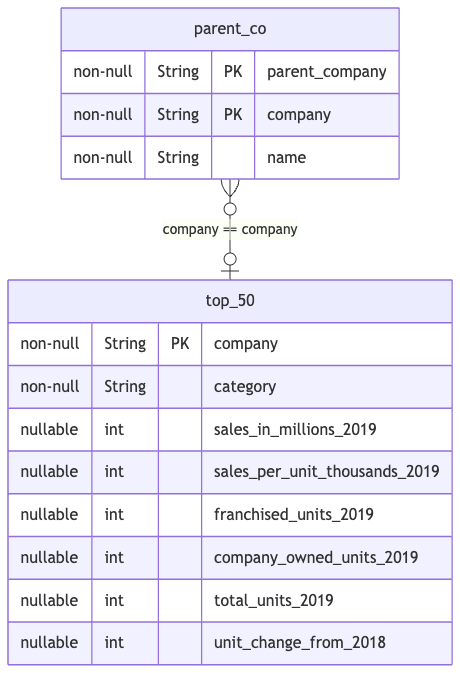

In [6]:
cube = session.create_cube(base_tbl, "Fast food analysis")
session.tables.schema

### Create measures

In [7]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [8]:
m["sales_in_millions"] = tt.agg.sum(enrichment_tbl["sales_in_millions_2019"])
m["sales_per_unit_thousands"] = tt.agg.sum(
    enrichment_tbl["sales_per_unit_thousands_2019"]
)
m["franchised_units"] = tt.agg.sum(enrichment_tbl["franchised_units_2019"])
m["company_owned_units"] = tt.agg.sum(enrichment_tbl["company_owned_units_2019"])
m["total_units"] = tt.agg.sum(enrichment_tbl["total_units_2019"])
m["unit_change_from_2018"] = tt.agg.sum(enrichment_tbl["unit_change_from_2018"])
m["% franchised"] = m["franchised_units"] / m["total_units"]
m["% franchised"].formatter = "DOUBLE[0.00%]"

In [9]:
m

{'% franchised': <atoti.measure.Measure object at 0x117483b10>, 'company_owned_units': <atoti.measure.Measure object at 0x117480610>, 'contributors.COUNT': <atoti.measure.Measure object at 0x117483c50>, 'franchised_units': <atoti.measure.Measure object at 0x117471e50>, 'sales_in_millions': <atoti.measure.Measure object at 0x117471250>, 'sales_per_unit_thousands': <atoti.measure.Measure object at 0x117424090>, 'total_units': <atoti.measure.Measure object at 0x11744a650>, 'unit_change_from_2018': <atoti.measure.Measure object at 0x11744b290>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x11744b4d0>}

## Managing roles in Atoti

Let's create some constants for the userIDs of the users we will be creating.  

In [10]:
ADMIN_USER = "atoti_admin"
ATOTI_USER = "atoti_user"
INSPIRE_USER1 = "Inspire_user1"
INSPIRE_USER2 = "Inspire_user2"
INSPIRE_MANAGER = "Inspire_manager"
RESTAURANT_USER1 = "Restaurant_user1"
RESTAURANT_USER2 = "Restaurant_user2"
RESTAURANT_MANAGER = "Restaurant_manager"

### Atoti reserved roles  

The below roles are reserved in Atoti and should not be altered by users:

* `ROLE_ADMIN`: Able to access all objects in the web application.
* `ROLE_USER`: Able to access all data by default. Access to objects such as dashboards, folders, widgets, etc. is enabled only if sharing access is granted to the role.

💡 **Note:** All users, including the administrator, require the role `ROLE_USER` to be able to access the Atoti UI.

Let's assume the following users have been granted the following roles:

* *atoti_admin*: `ROLE_ADMIN`, `ROLE_USER`
* *atoti_user*: `ROLE_USER`

While both *atoti_admin* and *atoti_user* are able to access all data, *atoti\_admin* is able to access all objects such as folders and dashboards. The *atoti\_user* is only able to access the objects created by the user specifically. Objects created by other users can only be accessed upon granting shared access.

#### Share role configuration 

In Atoti version before v0.8.0, we assign the role `ROLE_SHARE` to users in order to be able to let them share objects such as dashboards, folders, widgets and filters. Both *atoti\_admin* and *atoti\_user* will not be able to share objects (via the "Share" icon as shown below) unless granted the role __ROLE_SHARE__.  

<img src="https://data.atoti.io/notebooks/security/img/share_function.png" width="50%"/>  

From version v0.8.0 onwards, the role `ROLE_SHARE` is removed. Instead, users with the role `ROLE_USER` will have the ability to perform sharing by default.  

<img src="https://data.atoti.io/notebooks/security/img/admin_share.png" width="50%"/>


We can configure the sharing permission from the Atoti Admin UI which is accessible from the link below. Login with a user that has the role `ROLE_ADMIN` assigned.

In [11]:
session.link / "admin"

http://localhost:9097/admin

#### Create technical users

In case we want to limit the users who has the ability to perform sharing, we can either update the `canShare` permission for `ROLE_USER` to `false` from the Admin UI; or we can use the rest service to do so.  

Let's create a [technical user](https://docs.atoti.io/latest/how_tos/secure_a_session.html#Technical-users) (also called service accounts) for updating the backend. Atoti automatically enables Basic Authentication on the session even though we are using OIDC authentication mechanism.

In [12]:
technical_user_name = "ATOTI_TECH_ADMIN"
technical_user_password = "password"

technical_user = session.security.basic_authentication.credentials[
    technical_user_name
] = technical_user_password
session.security.individual_roles[technical_user_name] = {"ROLE_USER", "ROLE_ADMIN"}

In [13]:
url = session.url
port = urlparse(url).port

response = requests.put(
    f"http://localhost:{port}/activeviam/content/rest/v7/files?path=ui/user_roles/ROLE_USER/permissions",
    auth=(technical_user_name, technical_user_password),
    json={
        "content": '{"canShare": false}',
        "owners": ["atoti_admin"],
        "readers": ["ROLE_USER"],
        "overwrite": True,
        "recursive": True,
    },
)

In the event we want to control the sharing rights using roles from Authentication providers, we can create the intended role in the Admin UI. For instance, suppose the role that is supposed to have sharing permission is call `ROLE_SHARE`, we can run the below request to create the role with `canShare` set to `true`.  

In [14]:
response = requests.put(
    f"http://localhost:{port}/activeviam/content/rest/v7/files?path=ui/user_roles/ROLE_SHARE/permissions",
    auth=(technical_user_name, technical_user_password),
    json={
        "content": '{"canShare": true}',
        "owners": [technical_user_name],
        "readers": ["ROLE_SHARE"],
        "overwrite": True,
        "recursive": True,
    },
)

In [15]:
response

<Response [200]>

Below is what we see in the Admin server:  

<img src="https://data.atoti.io/notebooks/security/img/role_share_permission.png" />  

Now, any users who are assigned the role `ROLE_SHARE` in Atoti will have the ability to perform sharing.

We will see later on how we can map the roles from Auth0 to the roles in Atoti.  

### Role creation with restrictions  

Data restriction is based on users' requirement. In our use case, we assumed two groups of users with data access limited to those of their parent company:
* Users belonging to parent company `Inspire Brands`.
* Users belonging to parent company `Restaurant Brands International Inc`.

Therefore, we will create two roles to apply the restrictions based on the `parent_company` column from the `parent_co` table. We will define key that is a tuple, consisting of the name of the table and its column, along with the restricted values imposed on it. 

💡 **Note:** 
* We can skip role creation if there are no restrictions imposed on the role. 
* The value provided under the restrictions is cap-sensitive.

In [16]:
ROLE_INSPIRE = "ATOTI_ROLE_INSPIRE"
ROLE_RESTAURANT = "ATOTI_ROLE_RESTAURANT"

session.tables.restrictions.update(
    {
        ROLE_INSPIRE: (base_tbl["parent_company"] == "Inspire Brands"),
        ROLE_RESTAURANT: (
            base_tbl["parent_company"] == "Restaurant Brands International Inc."
        ),
    }
)

#### Restrict access from combination of roles

Multiple roles can be assigned to the same user. To demonstrate how the access will change when this happens, we create some other roles that restrict data access by the restaurant category, i.e. column `category` from the table `top_50`.

In [17]:
ROLE_BURGER = "ATOTI_ROLE_BURGER"
ROLE_SANDWICH = "ATOTI_ROLE_SANDWICH"
ROLE_SNACK = "ATOTI_ROLE_SNACK"

session.tables.restrictions.update(
    {
        ROLE_BURGER: enrichment_tbl["category"] == "burger",
        ROLE_SANDWICH: enrichment_tbl["category"] == "sandwich",
        ROLE_SNACK: enrichment_tbl["category"] == "snack",
    }
)

When combined with the restricted role on the `parent_company`, user's access will be further restricted to based on the restriction of the added role.  

* For instance, users who are assigned the role __ATOTI_ROLE_BURGER__ will be able to access all the data under _burger_ category restaurants, regardless of the parent companies.  
* However, when the same user is also granted the role __ATOTI_ROLE_INSPIRE__, then the user can only access data of restaurants under parent company _Inspire Brands_ that is of category _burger_. 

### Role assignment in Atoti

#### Assign default roles to authenticated users

We can default the roles such as `ROLE_SHARE` for all users who are logged in successfully.  

In [18]:
session.security.oidc.default_roles.update(["ROLE_SHARE"])

💡 **Note:** Be careful when granting `ROLE_USER` to users by default as users with this role will be able to access the application and the available data. It might be a better option to grant `ROLE_USER` individually to the rightful users in the next step.

#### Map roles between Authentication Provider and Atoti

The names in the authentication provider can be different from those in Atoti. Roles are assigned to users in the authentication provider and associated to the Atoti roles in the `role_mapping` below.

In [19]:
session.security.oidc.role_mapping.update(
    {
        # authentication provider roles: [Atoti reserved roles]
        "AUTH0_ADMIN": ["ROLE_ADMIN"],
        "AUTH0_USER": ["ROLE_USER"],
        "AUTH0_ROLE_SHARE": ["ROLE_SHARE"],
        # authentication provider roles:  [user-defined roles]
        "AUTH0_ROLE_INSPIRE": [ROLE_INSPIRE],
        "AUTH0_ROLE_RESTAURANT": [ROLE_RESTAURANT],
        "AUTH0_ROLE_BURGER": [ROLE_BURGER],
        "AUTH0_ROLE_SANDWICH": [ROLE_SANDWICH],
        "AUTH0_ROLE_SNACK": [ROLE_SNACK],
    }
)

While a role from the authentication provider can be mapped to multiple Atoti roles, it is easier to modify user's access by updating the roles in the authentication provider. It is a design consideration whether to have a one-to-one role map or to grant multiple Atoti roles to an authentication provider role.  

For example, by mapping `AUTH0_USER: [ROLE_USER, ROLE_SHARE]` in Atoti code** meant that all the users with __AUTH0_USER__ role assigned will be able access the web application and to do sharing. Alternatively, when we code map the **AUTH0 roles individually to each reserved role** as listed in the previous cell, individual users are granted the roles __AUTH0_USER__ and __AUTH0_ROLE_SHARE__ in Auth0 as shown below. Users will be able to modify the role assignment from Auth0 instead of performing code updates.

<img src="https://data.atoti.io/notebooks/security/img/auth0_roles_assignment.png" width="50%" />

## Testing authentication and authorization

Try out any of these users:

💡 **Note:** We recommend navigating to the Atoti UI in incognito mode so that switching between Google users is more seamless.

* Administrator
  * *atoti_admin*
* Generic user
  * *atoti_user*
* Inspire Brands users
  * *Inspire_user1* (Access for restaurants of category Burger only)
  * *Inspire_user2* (Access for restaurants of category Sandwich and Snack only)
  * *Inspire_manager*
* Restaurant Brands International LLC users
  * *Restaurant_user1* (Access for restaurants of category Burger only)
  * *Restaurant_user2* (Access for restaurants of category Sandwich and Snack only)
  * *Restaurant_manager*

In [20]:
session.link

http://localhost:9097

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=oidc-auth0" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>